In [35]:
import numpy as np
import os
import nibabel as nib
from nilearn import plotting
import matplotlib.pyplot as plt
from PIL import Image

In [3]:
base_data_dir = "/Users/kireet/ucb/HART Research/Muscle Segmentation/raw_nifti_scan"
os.listdir(base_data_dir)

['.DS_Store',
 'trial10_30_w1_seg_TRANS.nii',
 'trial10_30_w1_volume_TRANS.nii',
 'trial18_90_fs_seg_TRANS.nii',
 'trial18_90_fs_volume_TRANS.nii',
 'trial20_90_w1_seg_TRANS.nii',
 'trial20_90_w1_volume_TRANS.nii',
 'trial22_90_w3_seg_TRANS.nii',
 'trial22_90_w3_volume_TRANS.nii']

(1188, 482, 395)
(482, 395)


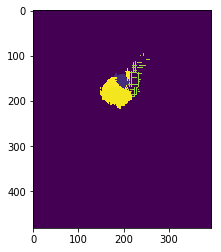

In [103]:
example_filename = os.path.join(base_data_dir, 'trial10_30_w1_seg_TRANS.nii')
# example_filename = os.path.join(base_data_dir, 'trial10_30_w1_volume_TRANS.nii')

voxel = nib.load(example_filename)
print(voxel.shape)

# plotting.plot_stat_map(img)
# plotting.show()

data1 = voxel.get_data()
x = 400
for i in data1[x-1:x]:
    print(i.shape)
#     print(i[200,:])
    plt.imshow(i)
    plt.show()
#     print(i.shape)
#     plotting.plot_stat_map(i)
#     plotting.show()

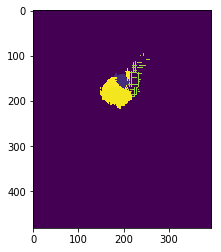

(482, 395)
(122, 110)


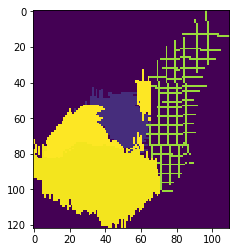

In [104]:
im = data1[x-1:x][0]
plt.imshow(im)
plt.show()
print(im.shape)

def bounding_box(img):
    rows = np.any(img, axis=1)
    cols = np.any(img, axis=0)
    rmin, rmax = np.where(rows)[0][[0, -1]]
    cmin, cmax = np.where(cols)[0][[0, -1]]
    box = im[rmin : rmax, cmin : cmax]
    return box
#     return rmin, rmax, cmin, cmax
box = bounding_box(im)
print(box.shape)
plt.imshow(box)
plt.show()

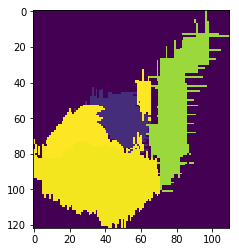

In [105]:
box = bounding_box(im)
def fill(image, threshold_dist=30):
    rows, cols = len(image), len(image[0])
    for u in range(rows):  # Iterate through rows
        for v in range(cols):  # Iterate through cols
            ltr_color, gtr_color, ltc_color, gtc_color = False, False, False, False
            for ltr in range(u, max(0, u-threshold_dist), -1):
                if image[ltr, v] != 0: 
                    ltr_color = image[ltr, v]
                    break
            for gtr in range(u, min(rows, u+threshold_dist)):
                if image[gtr, v] != 0: 
                    gtr_color = image[gtr, v]
                    break
            for ltc in range(v, max(0, v-threshold_dist), -1):
                if image[u, ltc] != 0: 
                    ltc_color = image[u, ltc]
                    break
            for gtc in range(v, min(cols, v+threshold_dist)):
                if image[u, gtc] != 0: 
                    gtc_color = image[u, gtc]
                    break
#             print([ltr_color, gtr_color, ltc_color, gtc_color])
            if np.all([ltr_color, gtr_color, ltc_color, gtc_color]):
                if len(set([ltr_color, gtr_color, ltc_color, gtc_color])) == 1:
                    image[u, v] = ltr_color
#               np.mean([ltr_color, gtr_color, ltc_color, gtc_color])
            
    return image

plt.imshow(fill(box))
plt.show()

In [75]:
x, y

(121, 109)